### Load necessary files and packages

In [1]:
from google.colab import files
uploaded = files.upload()

Saving flipkart_com-ecommerce_sample - flipkart_com-ecommerce_sample.xlsx to flipkart_com-ecommerce_sample - flipkart_com-ecommerce_sample.xlsx


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import nltk

# nltk.download('wordnet')
# nltk.download('stopwords')

Objects that will be used later in the code

In [2]:
Tokenizer = nltk.tokenize.TweetTokenizer()
Lemmatizer = nltk.stem.WordNetLemmatizer()

Imputer = KNNImputer()

ohe_name = OneHotEncoder(sparse=False)

name_le = LabelEncoder()
brand_le = LabelEncoder()
cat_le = LabelEncoder()

### Load the Dataset

In [3]:
dataset = pd.read_excel("flipkart_com-ecommerce_sample - flipkart_com-ecommerce_sample.xlsx")
dataset = dataset.drop(columns=["uniq_id", "crawl_timestamp", "image", "product_url", "pid", "product_specifications"])
dataset = dataset[dataset["description"].notna()]
dataset.head()

,product_name,product_category_tree,retail_price,discounted_price,is_FK_Advantage_product,description,product_rating,overall_rating,brand
0,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",999.0,379.0,False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha
1,FabHomeDecor Fabric Double Sofa Bed,"[""Furniture >> Living Room Furniture >> Sofa B...",32157.0,22646.0,False,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,No rating available,No rating available,FabHomeDecor
2,AW Bellies,"[""Footwear >> Women's Footwear >> Ballerinas >...",999.0,499.0,False,Key Features of AW Bellies Sandals Wedges Heel...,No rating available,No rating available,AW
3,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",699.0,267.0,False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha
4,Sicons All Purpose Arnica Dog Shampoo,"[""Pet Supplies >> Grooming >> Skin & Coat Care...",220.0,210.0,False,Specifications of Sicons All Purpose Arnica Do...,No rating available,No rating available,Sicons


### Data Analysis & Cleaning


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19998 entries, 0 to 19999
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   product_name             19998 non-null  object 
 1   product_category_tree    19998 non-null  object 
 2   retail_price             19920 non-null  float64
 3   discounted_price         19920 non-null  float64
 4   is_FK_Advantage_product  19998 non-null  bool   
 5   description              19998 non-null  object 
 6   product_rating           19998 non-null  object 
 7   overall_rating           19998 non-null  object 
 8   brand                    14135 non-null  object 
dtypes: bool(1), float64(2), object(6)
memory usage: 1.4+ MB


Create column <b><i>PRODUCT CATEGORY</i></b> from product_category_tree

In [5]:
dataset["product_category"] = dataset["product_category_tree"].str.split(" >>", 1).str[0].str.split("\"").str[1]

Get the mean number of samples for each product category

In [6]:
print("Min Count:", dataset["product_category"].value_counts().min())
print("Mean count:", dataset["product_category"].value_counts().mean())

Min Count: 1
Mean count: 75.46415094339622


Drop the product categories with number of samples < 100

In [7]:
dataset = dataset.groupby("product_category").filter(lambda x: len(x)>=100)

In [8]:
print("Min Count:", dataset["product_category"].value_counts().min())
print("Unique Categories:", len(dataset["product_category"].unique()))

Min Count: 166
Unique Categories: 18


Label encode the columns

In [9]:
dataset["product_name"] = name_le.fit_transform(dataset["product_name"])

dataset["product_category"] = cat_le.fit_transform(dataset["product_category"])

dataset["is_FK_Advantage_product"] = pd.to_numeric(dataset["is_FK_Advantage_product"], errors='coerce')

dataset["product_rating"] = pd.to_numeric(dataset["product_rating"], errors='coerce')

dataset["overall_rating"] = pd.to_numeric(dataset["overall_rating"], errors='coerce')

dataset["brand"] = dataset["brand"].astype("str")
dataset["brand"] = brand_le.fit_transform(dataset["brand"])

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19287 entries, 0 to 19999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   product_name             19287 non-null  int64  
 1   product_category_tree    19287 non-null  object 
 2   retail_price             19225 non-null  float64
 3   discounted_price         19225 non-null  float64
 4   is_FK_Advantage_product  19287 non-null  bool   
 5   description              19287 non-null  object 
 6   product_rating           1797 non-null   float64
 7   overall_rating           1797 non-null   float64
 8   brand                    19287 non-null  int64  
 9   product_category         19287 non-null  int64  
dtypes: bool(1), float64(4), int64(3), object(2)
memory usage: 1.5+ MB


Drop the columns which are unnecessary

In [10]:
dataset = dataset.drop(columns=["product_rating", "overall_rating", "product_category_tree"])
dataset[["retail_price"]] = Imputer.fit_transform(dataset[["retail_price"]])
dataset[["discounted_price"]] = Imputer.fit_transform(dataset[["discounted_price"]])
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19287 entries, 0 to 19999
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   product_name             19287 non-null  int64  
 1   retail_price             19287 non-null  float64
 2   discounted_price         19287 non-null  float64
 3   is_FK_Advantage_product  19287 non-null  bool   
 4   description              19287 non-null  object 
 5   brand                    19287 non-null  int64  
 6   product_category         19287 non-null  int64  
dtypes: bool(1), float64(2), int64(3), object(1)
memory usage: 1.0+ MB


###### Visualize the data

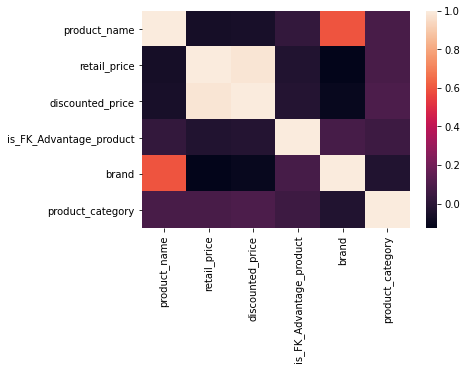

In [11]:
sns.heatmap(dataset.corr())

If some columns have very high correlation, then only one of them is required. For example: in this case retail price and discounted price are highly correlated. Similary, product name and brand are also highly correlated. Hence only of the highly correlated columns is kept for the input dataset

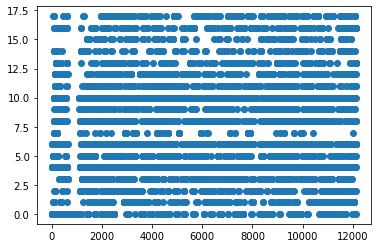

In [12]:
plt.scatter(dataset["product_name"], dataset["product_category"])

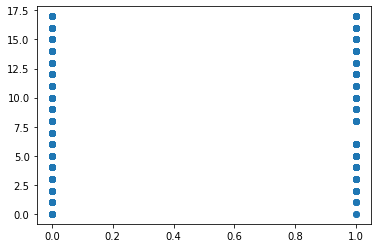

In [13]:
plt.scatter(dataset["is_FK_Advantage_product"], dataset["product_category"])

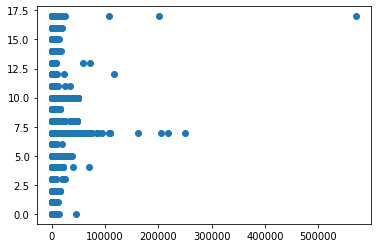

In [14]:
plt.scatter(dataset["retail_price"], dataset["product_category"])

### Choose the columns (other than product descrption) as input columns and pre-process them

In [15]:
prod_name = ohe_name.fit_transform(dataset[["product_name"]])
retail_price = np.asarray(dataset[["retail_price"]])
advantage_product = np.asarray(dataset[["is_FK_Advantage_product"]])

In [16]:
prod_name.shape, retail_price.shape, advantage_product.shape

((19287, 12136), (19287, 1), (19287, 1))

#### Create input samples for product description
The maximum input length is chosen by calculating the mean length of the product description.<br />
The product description is pre-processed. Pre-processing includes: Tokenization, Stop Word Removal and Lemmatization <br />
The description having length < max_input_len are padded with 0's and for description having length > max_input_len, only the latest max_input_len words are taken.

In [17]:
bow = set()
word_to_id = {"PADDING": 0}
id_to_word = {0: "PADDING"}
id = 1

lengths = []
input_len = int(dataset["description"].str.len().mean())
description_trans = []
for i, row in dataset.iterrows():
  description = row["description"]
  word = Tokenizer.tokenize(description)
  stop_words = nltk.corpus.stopwords.words("english")
  filtered_sent = []
  lengths.append(len(word))
  for w in word:
    if w not in stop_words:
      w = Lemmatizer.lemmatize(w)
      bow.add(w)
      if word_to_id.get(w) is None:
        word_to_id[w] = id
        id_to_word[id] = w
        id += 1
      filtered_sent.append(word_to_id[w])
  filtered_sent = filtered_sent[:input_len]
  filtered_sent = np.pad(filtered_sent, (0,input_len-len(filtered_sent)), "constant", constant_values=0)
  description_trans.append(filtered_sent)
description_trans = np.asarray(description_trans)

### Create Input Dataset

In [18]:
X_description = description_trans
X_meta = np.hstack([prod_name, retail_price, advantage_product])
Y = np.asarray(dataset[["product_category"]])

In [19]:
X_description.shape, X_meta.shape, Y.shape

((19287, 422), (19287, 12138), (19287, 1))

### Train-Test Split

In [20]:
d_train, d_test, m_train, m_test, y_train, y_test = train_test_split(X_description, X_meta, Y, test_size=0.50, random_state=42)

In [21]:
print("Vocabulary Size:", id)

Vocabulary Size: 33842


# Experiments with different models

### Method for creating model

In [22]:
def Model(x_description, x_meta, embed_size=32, LSTM=128, dropout=0.25):
  input_description = tf.keras.layers.Input(shape=x_description)
  x = tf.keras.layers.Embedding(id, embed_size, mask_zero=True, input_length=input_len)(input_description)
  x = tf.keras.layers.Dropout(dropout)(x)

  x = tf.keras.layers.LSTM(LSTM, return_sequences=True)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(dropout)(x)

  x = tf.keras.layers.LSTM(LSTM*2)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(dropout)(x)

  input_meta = tf.keras.layers.Input(shape=x_meta)
  x = tf.keras.layers.Concatenate()([x, input_meta])
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Dense(4086)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation(tf.nn.leaky_relu)(x)
  x = tf.keras.layers.Dropout(dropout)(x)

  x = tf.keras.layers.Dense(1024)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation(tf.nn.leaky_relu)(x)
  x = tf.keras.layers.Dropout(dropout)(x)
  
  x = tf.keras.layers.Dense(len(dataset["product_category"].unique()))(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation(tf.nn.softmax)(x)
  return tf.keras.Model([input_description, input_meta], x)

### Model-1

In [24]:
category_prediction_model_32_128 = Model(X_description[0].shape, X_meta[0].shape)
category_prediction_model_32_128.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics="accuracy")
category_prediction_model_32_128.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 422)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 422, 32)      1082944     input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 422, 32)      0           embedding[0][0]                  
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 422, 128)     82432       dropout[0][0]                    
______________________________________________________________________________________________

In [25]:
checkpoint_callback =   tf.keras.callbacks.ModelCheckpoint(filepath='weights_32_128/', save_weights_only=True, save_best_only=True, monitor="val_accuracy", mode="max")
H = category_prediction_model_32_128.fit([d_train, m_train], y_train, validation_split=0.25, epochs=50, batch_size=256, shuffle=True, callbacks=[checkpoint_callback])

Epoch 1/50
29/29 [==============================] - 52s 462ms/step - loss: 2.0925 - accuracy: 0.4627 - val_loss: 2.7990 - val_accuracy: 0.1431
Epoch 2/50
29/29 [==============================] - 10s 343ms/step - loss: 1.0312 - accuracy: 0.8985 - val_loss: 2.8274 - val_accuracy: 0.0651
Epoch 3/50
29/29 [==============================] - 10s 341ms/step - loss: 0.7189 - accuracy: 0.9794 - val_loss: 2.7398 - val_accuracy: 0.0303
Epoch 4/50
29/29 [==============================] - 10s 339ms/step - loss: 0.6013 - accuracy: 0.9920 - val_loss: 2.6209 - val_accuracy: 0.0601
Epoch 5/50
29/29 [==============================] - 10s 344ms/step - loss: 0.5381 - accuracy: 0.9926 - val_loss: 2.4432 - val_accuracy: 0.2360
Epoch 6/50
29/29 [==============================] - 10s 340ms/step - loss: 0.4891 - accuracy: 0.9977 - val_loss: 2.3098 - val_accuracy: 0.5384
Epoch 7/50
29/29 [==============================] - 10s 341ms/step - loss: 0.4900 - accuracy: 0.9857 - val_loss: 1.9668 - val_accuracy: 0.6537

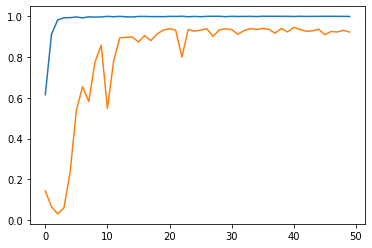

In [26]:
plt.plot(H.history["accuracy"])
plt.plot(H.history["val_accuracy"])

### Model-2

In [27]:
category_prediction_model_32_256 = Model(X_description[0].shape, X_meta[0].shape, LSTM=256)
category_prediction_model_32_256.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics="accuracy")

In [28]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='weights_32_256/', save_weights_only=True, save_best_only=True, monitor="val_accuracy", mode="max")
H = category_prediction_model_32_256.fit([d_train, m_train], y_train, validation_split=0.25, epochs=50, batch_size=256, shuffle=True, callbacks=[checkpoint_callback])

Epoch 1/50
29/29 [==============================] - 28s 615ms/step - loss: 2.1268 - accuracy: 0.4583 - val_loss: 2.7384 - val_accuracy: 0.2335
Epoch 2/50
29/29 [==============================] - 15s 515ms/step - loss: 1.1567 - accuracy: 0.8472 - val_loss: 2.7807 - val_accuracy: 0.2655
Epoch 3/50
29/29 [==============================] - 15s 510ms/step - loss: 0.8627 - accuracy: 0.9347 - val_loss: 2.8599 - val_accuracy: 0.0904
Epoch 4/50
29/29 [==============================] - 15s 509ms/step - loss: 0.6870 - accuracy: 0.9683 - val_loss: 2.7844 - val_accuracy: 0.1012
Epoch 5/50
29/29 [==============================] - 15s 508ms/step - loss: 0.6024 - accuracy: 0.9851 - val_loss: 2.4966 - val_accuracy: 0.3924
Epoch 6/50
29/29 [==============================] - 15s 515ms/step - loss: 0.5111 - accuracy: 0.9944 - val_loss: 2.8195 - val_accuracy: 0.1377
Epoch 7/50
29/29 [==============================] - 15s 513ms/step - loss: 0.4798 - accuracy: 0.9951 - val_loss: 2.6913 - val_accuracy: 0.2248

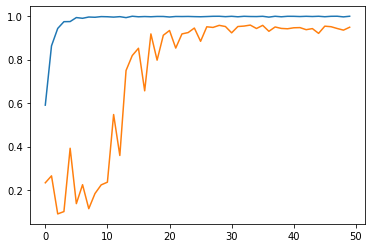

In [29]:
plt.plot(H.history["accuracy"])
plt.plot(H.history["val_accuracy"])

### Model-3

In [30]:
category_prediction_model_32_512 = Model(X_description[0].shape, X_meta[0].shape, LSTM=512)
category_prediction_model_32_512.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics="accuracy")

In [31]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='weights_32_512/', save_weights_only=True, save_best_only=True, monitor="val_accuracy", mode="max")
H = category_prediction_model_32_512.fit([d_train, m_train], y_train, validation_split=0.25, epochs=50, batch_size=256, shuffle=True, callbacks=[checkpoint_callback])

Epoch 1/50
29/29 [==============================] - 45s 1s/step - loss: 2.2280 - accuracy: 0.4253 - val_loss: 2.7410 - val_accuracy: 0.3621
Epoch 2/50
29/29 [==============================] - 32s 1s/step - loss: 1.4239 - accuracy: 0.7435 - val_loss: 2.6800 - val_accuracy: 0.2107
Epoch 3/50
29/29 [==============================] - 32s 1s/step - loss: 1.0311 - accuracy: 0.8847 - val_loss: 2.9497 - val_accuracy: 0.0755
Epoch 4/50
29/29 [==============================] - 32s 1s/step - loss: 0.7900 - accuracy: 0.9477 - val_loss: 3.0257 - val_accuracy: 0.0879
Epoch 5/50
29/29 [==============================] - 32s 1s/step - loss: 0.6393 - accuracy: 0.9793 - val_loss: 3.0675 - val_accuracy: 0.1107
Epoch 6/50
29/29 [==============================] - 32s 1s/step - loss: 0.5642 - accuracy: 0.9873 - val_loss: 2.5663 - val_accuracy: 0.2045
Epoch 7/50
29/29 [==============================] - 32s 1s/step - loss: 0.4930 - accuracy: 0.9893 - val_loss: 2.8830 - val_accuracy: 0.1837
Epoch 8/50
29/29 [==

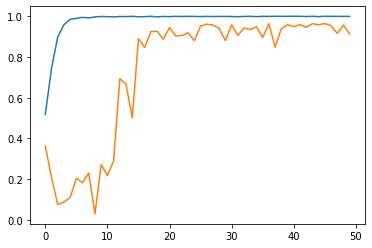

In [32]:
plt.plot(H.history["accuracy"])
plt.plot(H.history["val_accuracy"])

### Model-4

In [33]:
category_prediction_model_64_128 = Model(X_description[0].shape, X_meta[0].shape, embed_size=64)
category_prediction_model_64_128.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics="accuracy")

In [34]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='weights_64_128/', save_weights_only=True, save_best_only=True, monitor="val_accuracy", mode="max")
H = category_prediction_model_64_128.fit([d_train, m_train], y_train, validation_split=0.25, epochs=50, batch_size=256, shuffle=True, callbacks=[checkpoint_callback])

Epoch 1/50
29/29 [==============================] - 23s 453ms/step - loss: 2.0114 - accuracy: 0.5165 - val_loss: 2.8592 - val_accuracy: 0.0784
Epoch 2/50
29/29 [==============================] - 10s 352ms/step - loss: 0.9297 - accuracy: 0.9224 - val_loss: 2.8583 - val_accuracy: 0.0606
Epoch 3/50
29/29 [==============================] - 10s 355ms/step - loss: 0.6708 - accuracy: 0.9835 - val_loss: 2.7920 - val_accuracy: 0.0659
Epoch 4/50
29/29 [==============================] - 10s 356ms/step - loss: 0.5926 - accuracy: 0.9866 - val_loss: 2.5777 - val_accuracy: 0.2559
Epoch 5/50
29/29 [==============================] - 10s 359ms/step - loss: 0.5170 - accuracy: 0.9953 - val_loss: 2.5779 - val_accuracy: 0.2173
Epoch 6/50
29/29 [==============================] - 10s 354ms/step - loss: 0.5225 - accuracy: 0.9863 - val_loss: 2.1999 - val_accuracy: 0.4421
Epoch 7/50
29/29 [==============================] - 10s 358ms/step - loss: 0.4311 - accuracy: 0.9960 - val_loss: 1.6286 - val_accuracy: 0.7536

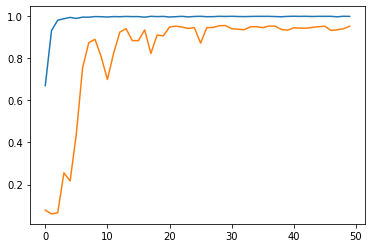

In [35]:
plt.plot(H.history["accuracy"])
plt.plot(H.history["val_accuracy"])

### Model-5

In [36]:
category_prediction_model_64_256 = Model(X_description[0].shape, X_meta[0].shape, embed_size=64, LSTM=256)
category_prediction_model_64_256.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics="accuracy")

In [37]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='weights_64_256/', save_weights_only=True, save_best_only=True, monitor="val_accuracy", mode="max")
H = category_prediction_model_64_256.fit([d_train, m_train], y_train, validation_split=0.25, epochs=50, batch_size=256, shuffle=True, callbacks=[checkpoint_callback])

Epoch 1/50
29/29 [==============================] - 29s 653ms/step - loss: 2.0774 - accuracy: 0.4851 - val_loss: 2.8438 - val_accuracy: 0.1307
Epoch 2/50
29/29 [==============================] - 15s 529ms/step - loss: 1.0714 - accuracy: 0.8737 - val_loss: 2.7814 - val_accuracy: 0.1083
Epoch 3/50
29/29 [==============================] - 15s 528ms/step - loss: 0.7905 - accuracy: 0.9475 - val_loss: 2.7094 - val_accuracy: 0.1796
Epoch 4/50
29/29 [==============================] - 15s 531ms/step - loss: 0.6393 - accuracy: 0.9733 - val_loss: 2.5397 - val_accuracy: 0.4716
Epoch 5/50
29/29 [==============================] - 15s 530ms/step - loss: 0.6208 - accuracy: 0.9674 - val_loss: 2.7727 - val_accuracy: 0.2447
Epoch 6/50
29/29 [==============================] - 15s 528ms/step - loss: 0.4823 - accuracy: 0.9940 - val_loss: 2.2133 - val_accuracy: 0.4762
Epoch 7/50
29/29 [==============================] - 15s 526ms/step - loss: 0.4648 - accuracy: 0.9942 - val_loss: 1.9229 - val_accuracy: 0.5910

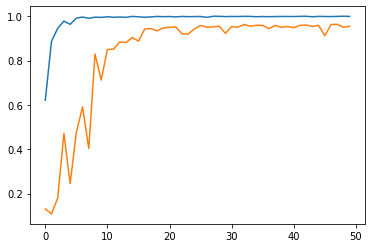

In [41]:
plt.plot(H.history["accuracy"])
plt.plot(H.history["val_accuracy"])

### Model-6

In [23]:
category_prediction_model_64_512 = Model(X_description[0].shape, X_meta[0].shape, embed_size=64, LSTM=512)
category_prediction_model_64_512.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics="accuracy")

In [24]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='weights_64_512/', save_weights_only=True, save_best_only=True, monitor="val_accuracy", mode="max")
H = category_prediction_model_64_512.fit([d_train, m_train], y_train, validation_split=0.25, epochs=50, batch_size=256, shuffle=True, callbacks=[checkpoint_callback])

Epoch 1/50
29/29 [==============================] - 56s 1s/step - loss: 2.2613 - accuracy: 0.4143 - val_loss: 2.5398 - val_accuracy: 0.3447
Epoch 2/50
29/29 [==============================] - 32s 1s/step - loss: 1.4866 - accuracy: 0.7263 - val_loss: 2.5689 - val_accuracy: 0.3509
Epoch 3/50
29/29 [==============================] - 32s 1s/step - loss: 0.9725 - accuracy: 0.8928 - val_loss: 2.9517 - val_accuracy: 0.0402
Epoch 4/50
29/29 [==============================] - 32s 1s/step - loss: 0.7555 - accuracy: 0.9518 - val_loss: 2.5607 - val_accuracy: 0.1866
Epoch 5/50
29/29 [==============================] - 32s 1s/step - loss: 0.6194 - accuracy: 0.9762 - val_loss: 2.5750 - val_accuracy: 0.3928
Epoch 6/50
29/29 [==============================] - 33s 1s/step - loss: 0.4884 - accuracy: 0.9945 - val_loss: 2.9452 - val_accuracy: 0.0896
Epoch 7/50
29/29 [==============================] - 35s 1s/step - loss: 0.4760 - accuracy: 0.9895 - val_loss: 2.5376 - val_accuracy: 0.1576
Epoch 8/50
29/29 [==

CancelledError: ignored

In [ ]:
plt.plot(H.history["accuracy"])
plt.plot(H.history["val_accuracy"])

### Load all the models with best weights and evaluate

In [26]:
category_prediction_model_32_128.load_weights('weights_32_128/')
print("Embed Size: 32, LSTM: 128")
print("\tTrain Accuracy:", category_prediction_model_32_128.evaluate([d_train, m_train], y_train, verbose=0)[1], "Test Accuracy:", category_prediction_model_32_128.evaluate([d_test, m_test], y_test, verbose=0)[1])
del category_prediction_model_32_128

category_prediction_model_32_256.load_weights('weights_32_256/')
print("Embed Size: 32, LSTM: 256")
print("\tTrain Accuracy:", category_prediction_model_32_256.evaluate([d_train, m_train], y_train, verbose=0)[1], "Test Accuracy:", category_prediction_model_32_256.evaluate([d_test, m_test], y_test, verbose=0)[1])
del category_prediction_model_32_256

category_prediction_model_32_512.load_weights('weights_32_512/')
print("Embed Size: 32, LSTM: 512")
print("\tTrain Accuracy:", category_prediction_model_32_512.evaluate([d_train, m_train], y_train, verbose=0)[1], "Test Accuracy:", category_prediction_model_32_512.evaluate([d_test, m_test], y_test, verbose=0)[1])
del category_prediction_model_32_512

category_prediction_model_64_128.load_weights('weights_64_128/')
print("Embed Size: 64, LSTM: 128")
print("\tTrain Accuracy:", category_prediction_model_64_128.evaluate([d_train, m_train], y_train, verbose=0)[1], "Test Accuracy:", category_prediction_model_64_128.evaluate([d_test, m_test], y_test, verbose=0)[1])
del category_prediction_model_64_128

category_prediction_model_64_256.load_weights('weights_64_256/')
print("Embed Size: 64, LSTM: 256")
print("\tTrain Accuracy:", category_prediction_model_64_256.evaluate([d_train, m_train], y_train, verbose=0)[1], "Test Accuracy:", category_prediction_model_64_256.evaluate([d_test, m_test], y_test, verbose=0)[1])
del category_prediction_model_64_256

category_prediction_model_64_512.load_weights('weights_64_512/')
print("Embed Size: 64, LSTM: 512")
print("\tTrain Accuracy:", category_prediction_model_64_512.evaluate([d_train, m_train], y_train, verbose=0)[1], "Test Accuracy:", category_prediction_model_64_512.evaluate([d_test, m_test], y_test, verbose=0)[1])
del category_prediction_model_64_512

Embed Size: 32, LSTM: 128
	Train Accuracy: 0.9858965277671814 Test Accuracy: 0.9356076121330261
Embed Size: 32, LSTM: 256
	Train Accuracy: 0.9893186688423157 Test Accuracy: 0.9509539604187012
Embed Size: 32, LSTM: 512
	Train Accuracy: 0.9907705187797546 Test Accuracy: 0.9598714113235474
Embed Size: 64, LSTM: 128
	Train Accuracy: 0.9885927438735962 Test Accuracy: 0.9510576725006104
Embed Size: 64, LSTM: 256
	Train Accuracy: 0.9905630946159363 Test Accuracy: 0.9568643569946289
Embed Size: 64, LSTM: 512
	Train Accuracy: 0.9921186566352844 Test Accuracy: 0.9651597142219543
